In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import json
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
import sklearn.cluster
import torch
import tqdm
import umap

import celltrip


mpl.rcParams['pdf.fonttype'] = 42


# Load Data

In [3]:
# Read data
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/ExpVal/expression.h5ad', backed=True)

# Model location and name
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/ExpVal-251120', 800

# Load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
adata.obs['Training'] = mask

# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')

# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');

# Simulate

In [ ]:
# Get untreated
# sample_mask = adata.obs['age']==6  # Age 6
sample_mask = np.ones(adata.shape[0], dtype=bool)  # All
sim_data = adata[sample_mask].X[:]
sim_data_norm = 10_000 * sim_data / sim_data.sum(axis=1)
sim_data_pre, = preprocessing.transform([sim_data])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(sim_data_pre), compute_rewards=False, dim=32).eval(time_scale=5).to('cuda')

# Compute steady state
ret = celltrip.train.simulate_until_completion(
    env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state = ret[-1][-1]
steady_state_pos = steady_state[..., :env.dim]
with torch.no_grad(): steady_state_gex = policy.pinning[0](steady_state_pos.to('cuda')).detach().cpu().numpy()
steady_state_gex, = preprocessing.inverse_transform(steady_state_gex, subset_modality=0)

## Visualize Observed

In [ ]:
# Reduce observed
import umap
red = umap.UMAP(random_state=42)
sim_data_embed = red.fit_transform(sim_data_norm)
sim_data_embed = pd.DataFrame(sim_data_embed, index=adata[sample_mask].obs_names, columns=[f'UMAP-{i}' for i in range(sim_data_embed.shape[1])])
sim_data_embed['subtype'] = adata.obs.loc[sample_mask, 'subtype']
sim_data_embed['sample'] = adata.obs.loc[sample_mask, 'sample']
sim_data_embed['source'] = 'Observed'

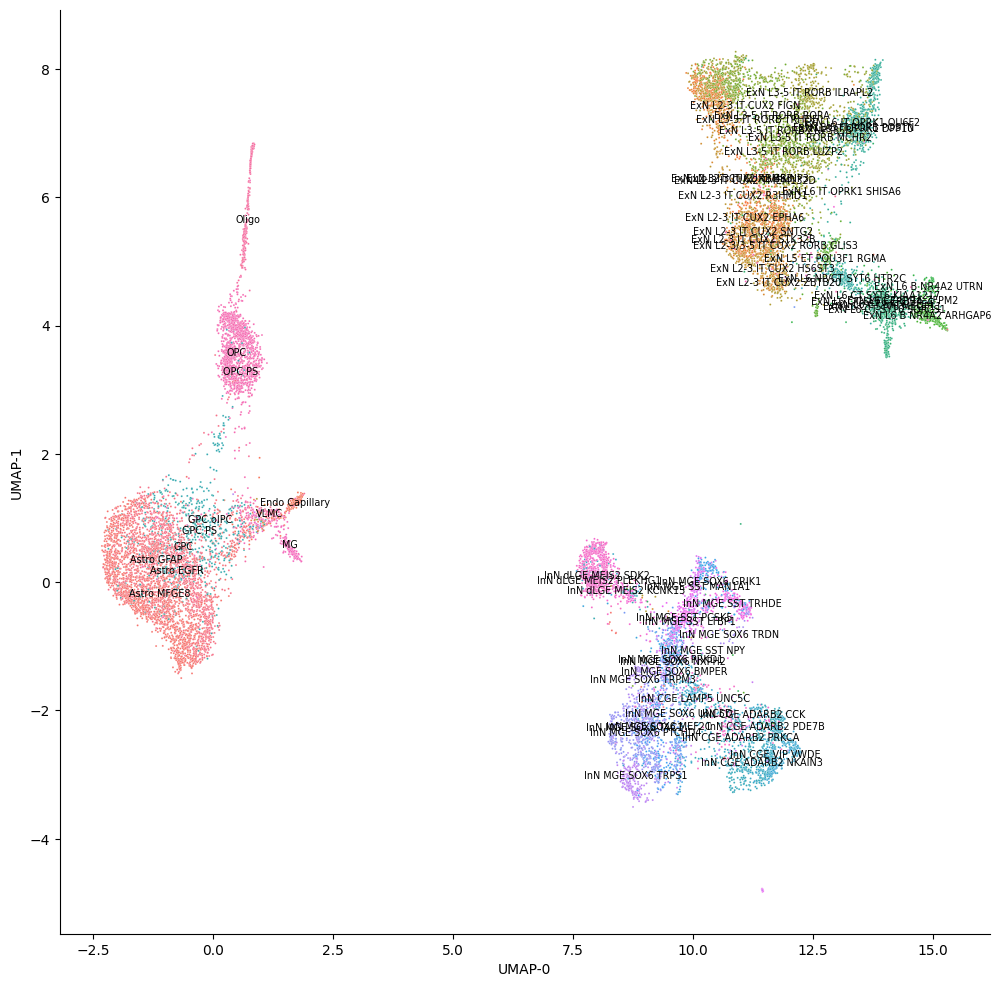

In [ ]:
# Plot observed
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(sim_data_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = sim_data_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

## Visualize CellTRIP

In [ ]:
# Reduce CellTRIP
steady_state_gex_embed = red.transform(steady_state_gex)  # np.concat([sim_data, steady_state_gex], axis=0)
steady_state_gex_embed = pd.DataFrame(steady_state_gex_embed, index=adata[sample_mask].obs_names, columns=[f'UMAP-{i}' for i in range(steady_state_gex_embed.shape[1])])
steady_state_gex_embed['subtype'] = adata.obs.loc[sample_mask, 'subtype']
steady_state_gex_embed['sample'] = adata.obs.loc[sample_mask, 'sample']
steady_state_gex_embed['source'] = 'CellTRIP'

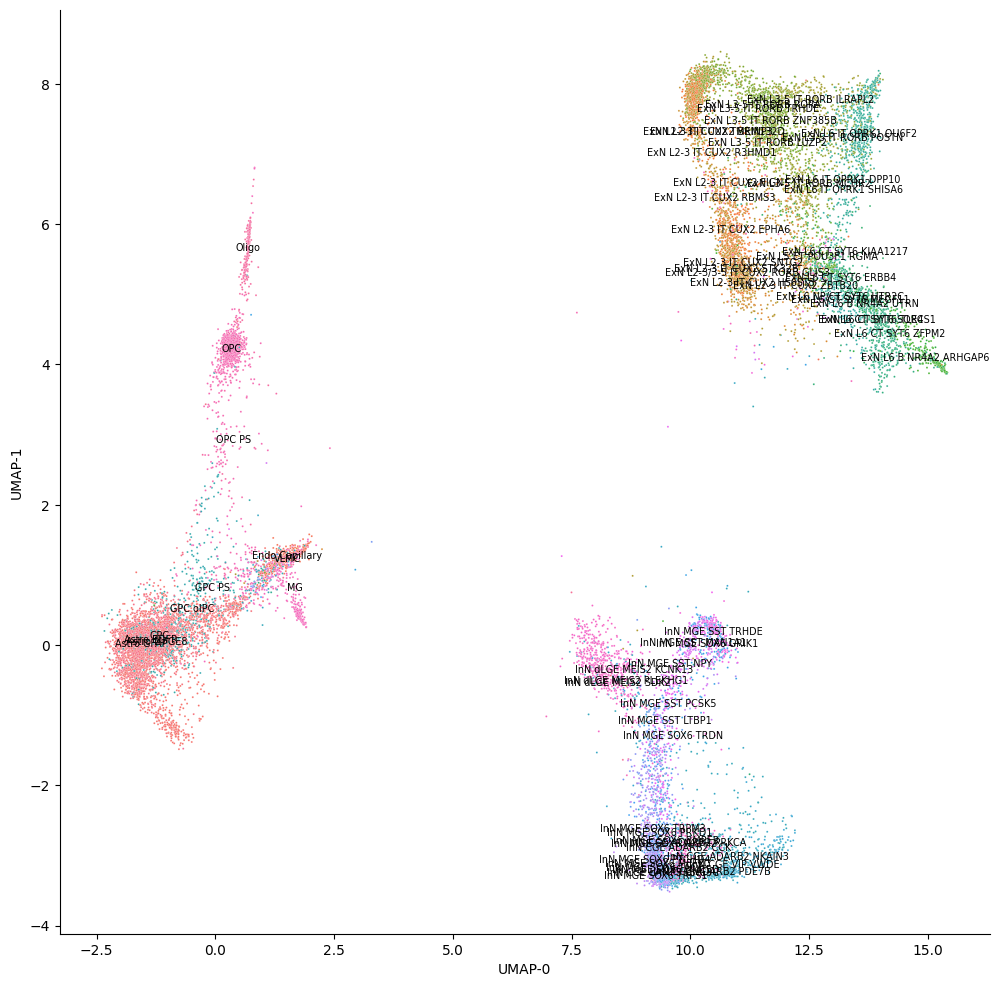

In [ ]:
# Plot CellTRIP
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(steady_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = steady_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

## Visualize Training and Validation

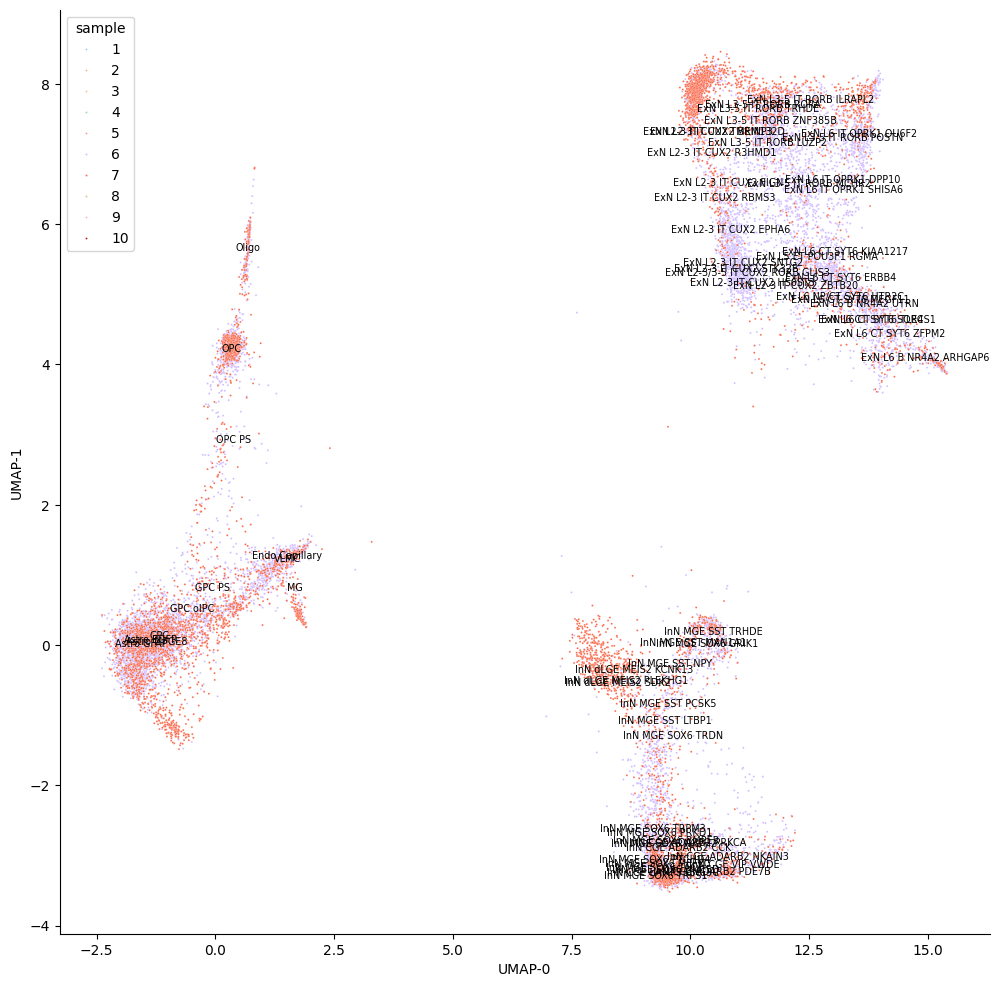

In [ ]:
# Get colors
sample_train = adata.obs.groupby('sample')['Train'].max()
hue_order = sample_train.index.to_numpy()
palette = np.zeros((sample_train.shape[0], 3))
palette[sample_train] = sns.color_palette('Purples', sample_train.sum())
palette[~sample_train] = sns.color_palette('Reds', (~sample_train).sum())
palette = palette.tolist()
# Plot CellTRIP samples
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(steady_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='sample', hue_order=hue_order, palette=palette, s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = steady_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

## Visualize Observed and CellTRIP

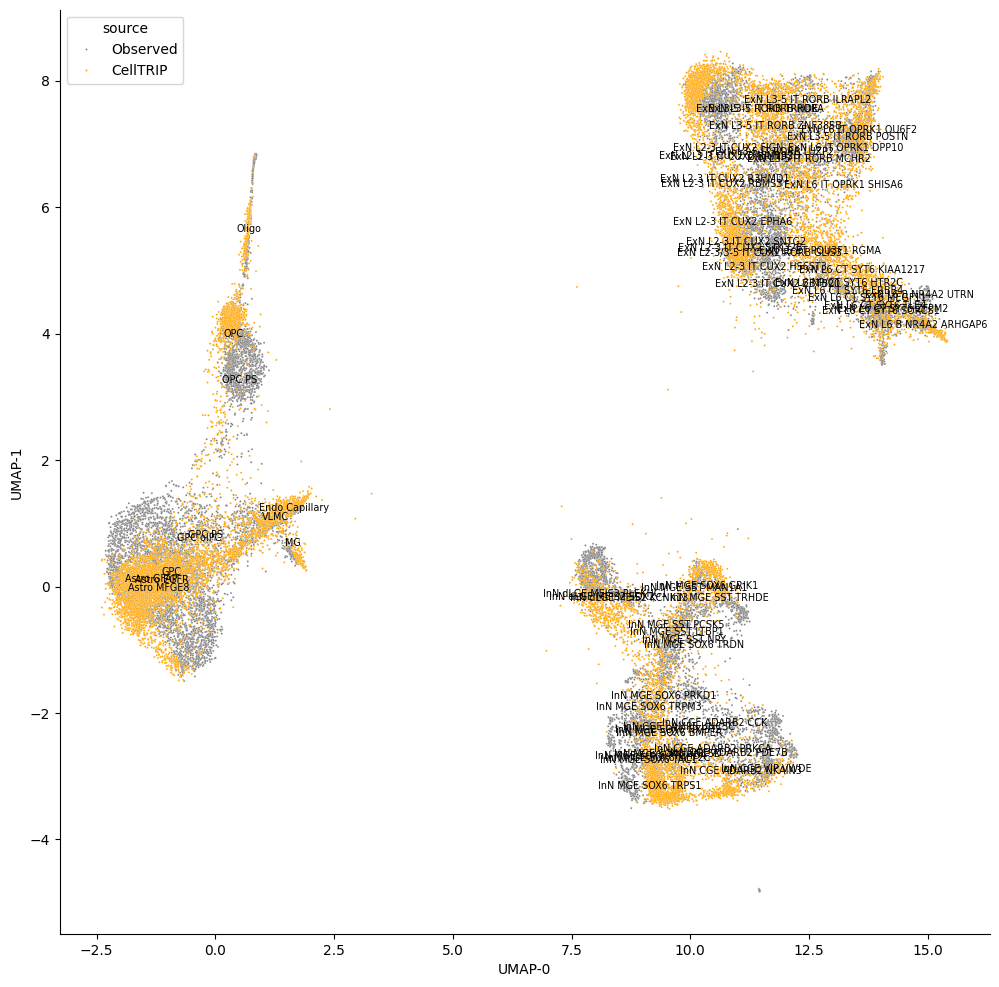

In [60]:
# Concatenate
concat_embed = pd.concat([sim_data_embed, steady_state_gex_embed], axis=0)

# Plot observed vs. CellTRIP
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(concat_embed, x='UMAP-0', y='UMAP-1', hue='source', palette=['gray', 'orange'], s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = concat_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

# Knock Down *RAPGEF4*

In [13]:
# Get target gene
target_gene = 'RAPGEF4'
gene_idx = [np.argmax(adata.var.index.to_numpy()==target_gene)]
sim_time, skip_states = 128., 100.

# Reset environment
env.reset().set_max_time(sim_time)
env.set_state(steady_state.to(env.device))
ret = celltrip.train.simulate_until_completion(
    env, policy,
    env_hooks=[
        # celltrip.utility.hooks.clamp_input_features_hook(
        #     gene_idx, preprocessing, feature_targets=0., modality_idx=0,
        #     device=env.device)
        celltrip.utility.hooks.clamp_inverted_features_hook(
            gene_idx, preprocessing, feature_targets=0., modality_idx=0),
    ],
    action_hooks=[],
    skip_states=skip_states, store_states='cpu', progress_bar=True)

# Impute last state
knocked_state_pos = ret[-1][-1, ..., :env.dim]
with torch.no_grad(): knocked_state_gex = policy.pinning[0](knocked_state_pos.to('cuda')).detach().cpu().numpy()
knocked_state_gex, = preprocessing.inverse_transform(knocked_state_gex, subset_modality=0)

1280it [03:40,  5.80it/s]


## Visualize Shift

In [14]:
# Reduce knocked
knocked_state_gex_embed = red.transform(knocked_state_gex)
knocked_state_gex_embed = pd.DataFrame(knocked_state_gex_embed, index=adata[sample_mask].obs_names, columns=[f'UMAP-{i}' for i in range(knocked_state_gex_embed.shape[1])])
knocked_state_gex_embed['subtype'] = adata.obs.loc[sample_mask, 'subtype']
knocked_state_gex_embed['sample'] = adata.obs.loc[sample_mask, 'sample']
knocked_state_gex_embed['source'] = 'CellTRIP Knockdown'

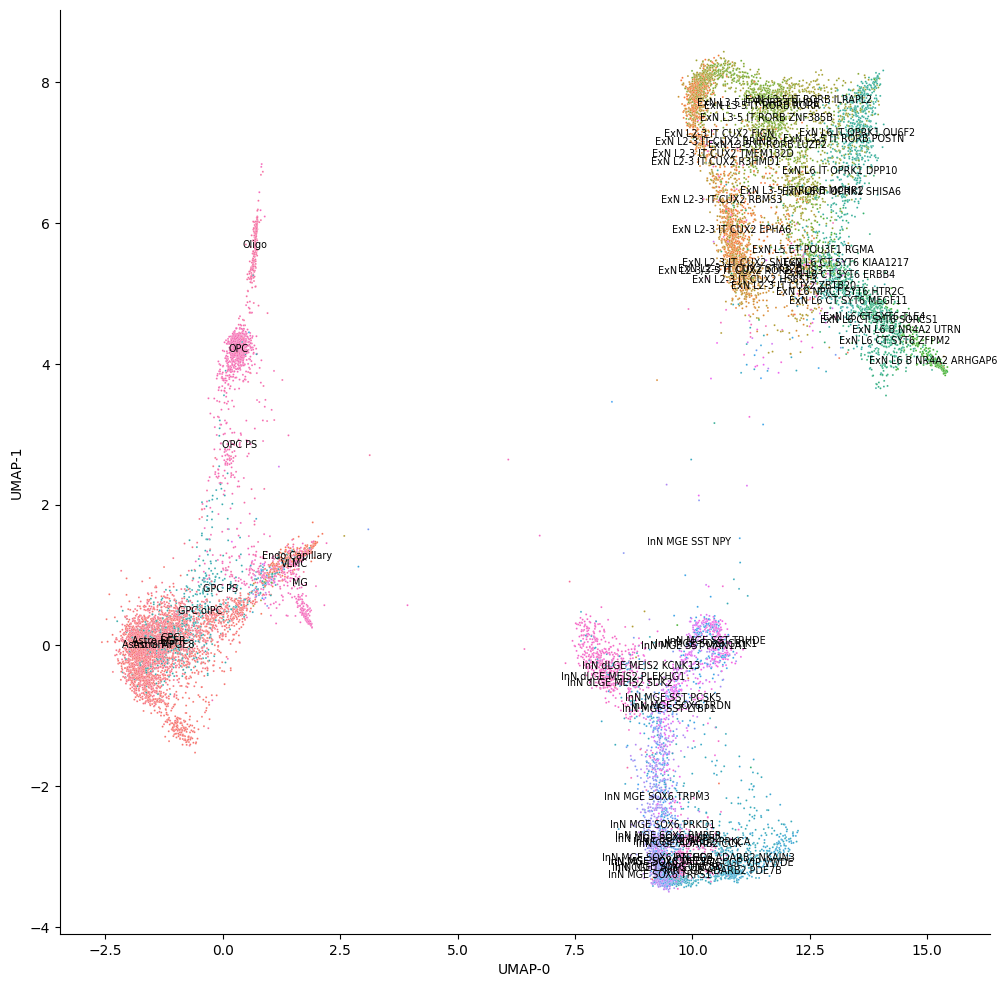

In [48]:
# Plot CellTRIP knockdown
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(knocked_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = knocked_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

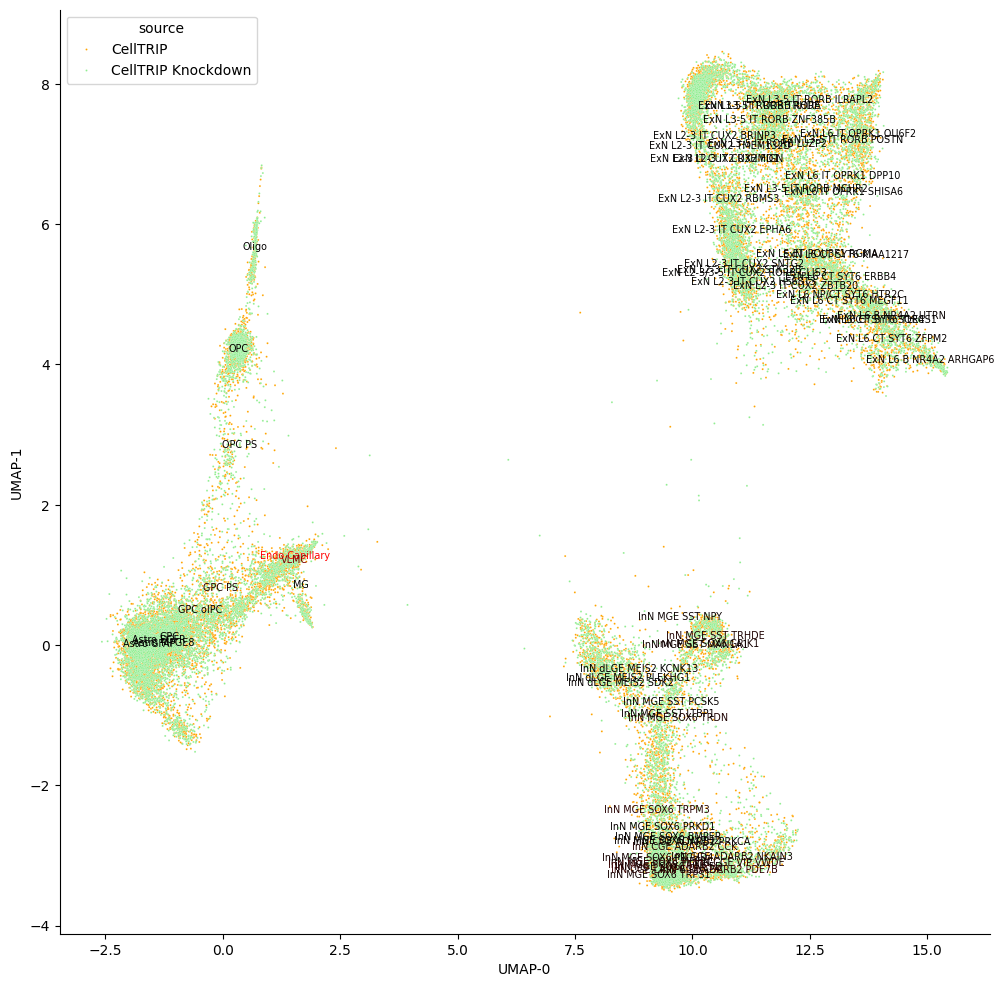

In [61]:
# Get mean subtype deviation
# diff = pd.DataFrame(knocked_state_gex - steady_state_gex, index=adata[sample_mask].obs_names, columns=adata[sample_mask].var_names)
diff = pd.DataFrame(index=adata[sample_mask].obs_names)
diff['Distance'] = np.square(knocked_state_gex - steady_state_gex).mean(axis=1)
diff['subtype'] = adata[sample_mask].obs['subtype']
subtype_diff = diff.groupby('subtype', observed=True).mean()
subtype_alpha = (subtype_diff / subtype_diff.max())['Distance']

# Concatenate
concat_embed = pd.concat([steady_state_gex_embed, knocked_state_gex_embed], axis=0)

# Plot CellTRIP vs. CellTRIP knockdown
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(concat_embed, x='UMAP-0', y='UMAP-1', hue='source', palette=['orange', 'lightgreen'], s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = concat_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(
        *r.to_numpy(), subtype,
        ha='center', va='center', fontsize='x-small',
        color=[subtype_alpha.loc[subtype], 0, 0],
        transform=ax.transData)